# Global Overturning Streamfunction

This scipt plots the global overturning streamfunction in density space for 3 ACCESS-OM2 simulations at different resolutions.

It also serves as a sample for how to compute and display diagnostics for the ACCESS-OM2 model evaluation paper.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 39656:127.0.0.1:39656 vdi-n6.nci.org.au -l aek156


Client Scheduler: tcp://127.0.0.1:36934 Dashboard: http://127.0.0.1:39656/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**For starters**, list the three experiments you want to use. For now, we will use RYF sample runs - in the future we hope to be using the full interannual forcing simulations. This script assumes that there are 3 experiments, and that they are ordered as 1°, 0.25° then 0.1°.

This function computes the overturning from ty_trans_rho. 

**TO DO:** 
* Alter this to compute over a specific date range.
* Avoid use of filesPerYear

In [3]:
def calc_psi_avg(expt, n=4):
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=n,
                          time_units = 'days since 1700-01-01')
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=n,
                              time_units = 'days since 1700-01-01')
        psiGM = psiGM.sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM.mean('time')
    
    ## This function basically splits the calculation up to save on memory:
    psi_avg = cc.compute_by_block(psi_avg)
    #psi_avg = psi_avg.compute()
    
    return psi_avg

Compute average overturning for each of the three simulations

In [4]:
# do 10 years - test at 1
n_years = 1

In [5]:
# 1° resolution
ekey = '1deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
# filesPerYear = exptdata.exptdict[ekey]['filesPerYear']
filesPerYear = 1 # BUG: value may be incorrect TODO: avoid this approach - just specify a date range
n_files = n_years*filesPerYear
print(n_files)
psi_avg_1 = calc_psi_avg(expt,n_files)
IPython.display.clear_output()

In [6]:
# 0.25° resolution
ekey = '025deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
# filesPerYear = exptdata.exptdict[ekey]['filesPerYear']
filesPerYear = 4 # BUG: value may be incorrect TODO: avoid this approach - just specify a date range
n_files = n_years*filesPerYear
print(n_files)
psi_avg_025 = calc_psi_avg(expt,n_files)
IPython.display.clear_output()

In [7]:
# 0.1° resolution - pretty slow if you use too many files
ekey = '01deg'
expt = exptdata.exptdict[ekey]['expt']
print(expt)
# filesPerYear = exptdata.exptdict[ekey]['filesPerYear']
filesPerYear = 12 # BUG: value may be incorrect TODO: avoid this approach - just specify a date range
n_files = n_years*filesPerYear
print(n_files)
psi_avg_01 = calc_psi_avg(expt,n_files)
IPython.display.clear_output()

This function plots the streamfunction.

In [8]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.curl,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

And here is the code to make the actual figure.

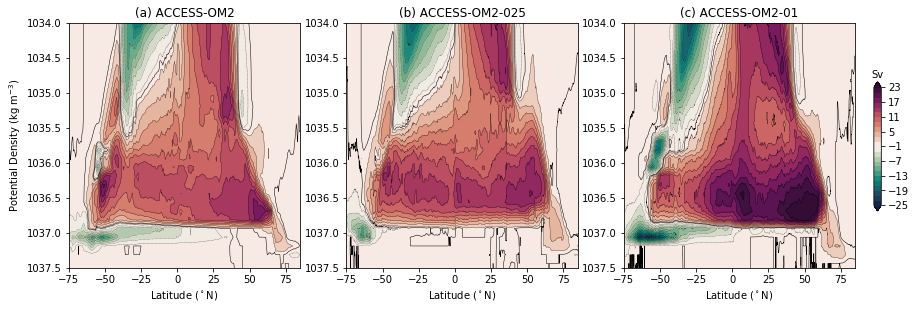

In [9]:
plt.figure(figsize=(13,4.5))
clev=np.arange(-25,25,2)
plt.subplot(131)
plot_psi(psi_avg_1,clev)
plt.title('(a) ACCESS-OM2')
plt.subplot(132)
p1 = plot_psi(psi_avg_025,clev)
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')
plt.subplot(133)
p1 = plot_psi(psi_avg_01,clev)
plt.ylabel('')
plt.title('(c) ACCESS-OM2-01')

plt.subplots_adjust(left=0.08,right=0.92)

ax1 = plt.axes([0.94,0.3,0.008,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Sv')

plt.savefig('mean_overturning.pdf')